In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy.linalg import inv
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from data.dataLoader import dataLoader
from fit.ConditionalLeastSquaresLogLin import ConditionalLeastSquaresLogLin
from inference.ParametricFit import ParametricFit
from simulation.Simulate import Simulate

from nphc.main import NPHC
from nphc.main import starting_point

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

2024-06-08 20:46:20.613751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


## Global Params

In [2]:
model_name = 'simulation-hawkes'
seed = 2
n_sims = 10
T = 100
inputs_path = os.path.join(os.getcwd(), 'data', 'inputs')
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')
cols = [
    "lo_deep_Ask", "co_deep_Ask", "lo_top_Ask", "co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
    "lo_inspread_Bid", "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid"
    ]
n_cols = len(cols)

# Generate Fake Data

## Create Fake Params

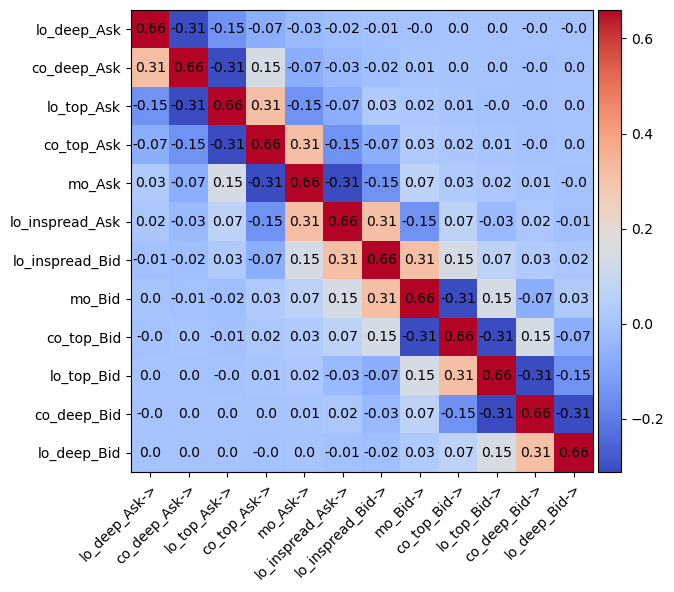

In [3]:
np.random.seed(seed)
mat = np.zeros((n_cols,n_cols))
for i in range(n_cols):
    mat[i][i] = .66
for i in range(n_cols):
    for j in range(n_cols):
        if i == j: continue
        mat[i][j] = np.random.choice([1,-1])*mat[i][i]*np.exp(-.75*np.abs(j-i))

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()

In [4]:
# norm should be less than 1
np.max(np.linalg.eig(mat)[0])

(0.9766447760657011+0j)

In [5]:
# create fake TOD params - 1.0 for now but can be changed to whatever you wish
faketod = {}
for k in cols:
    faketod[k] = {}
    for k1 in np.arange(13):
        faketod[k][k1] = 1.0

# check if dir exists
if not os.path.exists(os.path.join(inputs_path, model_name)):
    os.makedirs(os.path.join(inputs_path, model_name))

# save the fake data
with open(os.path.join(inputs_path, model_name, "fakeData_Params_sod_eod_dictTOD_constt"), "wb") as f:
    pickle.dump(faketod, f)

In [6]:
np.random.seed(seed)
# Create fake power law kernel params from the above norm matrix
paramsFake = {}
for i in range(n_cols):
    paramsFake[cols[i]] = 0.1*np.random.choice([0.3,0.4,0.5,0.6,0.7])
    for j in range(n_cols):
        maxTOD = np.max(list(faketod[cols[j]].values()))
        beta = np.random.choice([1.5,1.6,1.7,1.8,1.9])
        gamma = (1+np.random.rand())*5e3
        alpha = np.abs(mat[i][j])*gamma*(beta-1)/maxTOD
        paramsFake[cols[i]+"->"+cols[j]] = (np.sign(mat[i][j]), np.array([alpha, beta, gamma]))

In [7]:
mat = np.zeros((n_cols,n_cols))
for i in range(len(cols)):
    for j in range(len(cols)):
        kernelParams = paramsFake.get(cols[j]+"->"+cols[i], None)
        if kernelParams is None: continue
        mat[i][j] = kernelParams[0]*kernelParams[1][0]/((-1 + kernelParams[1][1])*kernelParams[1][2])

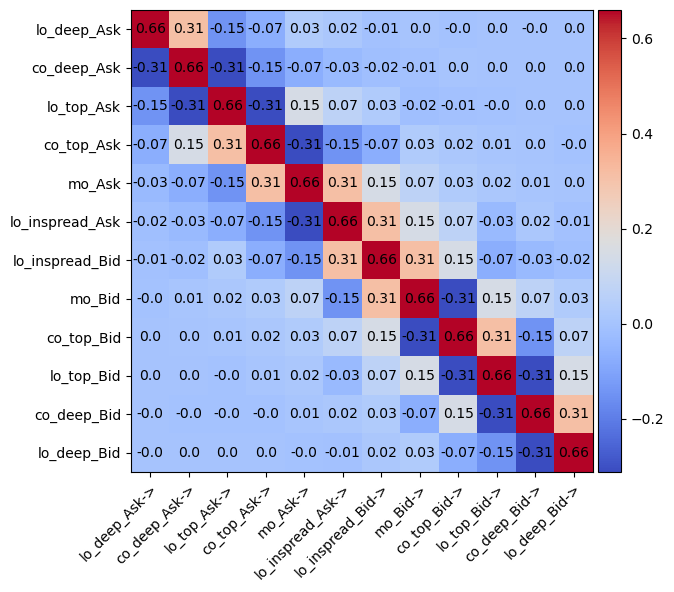

In [8]:
# norm matrix from this fake power law kernels - does it match the above figure? - YES.
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()


In [9]:
with open(os.path.join(inputs_path, model_name, "fake_ParamsInferredWCutoff_sod_eod_true"), "wb") as f:
    pickle.dump(paramsFake, f)

## Simulate Fake LOB Data

In [10]:
paramsPath = os.path.join(inputs_path, model_name, "fake_ParamsInferredWCutoff_sod_eod_true")
todPath = os.path.join(inputs_path, model_name, "fakeData_Params_sod_eod_dictTOD_constt")
simulate = Simulate()

# check if dir exists
if not os.path.exists(os.path.join(outputs_path, model_name)):
    os.makedirs(os.path.join(outputs_path, model_name))

#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(n_sims):
    Ts, lob, lobL3 = simulate.run(T=T, # 6.5*3600
                                 paramsPath=paramsPath, 
                                 todPath=todPath, 
                                 beta=1., 
                                 avgSpread=.01, 
                                 spread0=5, 
                                 price0=45,
                                 verbose=True)
    
    if len(pd.DataFrame(Ts[1:])[0].unique()) != len(cols):
        raise ValueError(f"Some columns are missing in the data 'T' for id = {i}")
    
    fakeSimPath = os.path.join(outputs_path, model_name, f"fake_simulated_sod_eod_{i}")

    with open(fakeSimPath, "wb") as f:
        pickle.dump((Ts, lob, lobL3), f)

spectral radius =  (0.9766447760656987+0j)
[0.03, 0.05, 0.03, 0.03, 0.04000000000000001, 0.1500000000000128, 0.20000000000001708, 0.03, 0.06999999999999999, 0.05, 0.06999999999999999, 0.06999999999999999]
0.8200000000000298
[0.03, 0.05, 0.03, 0.03, 0.04000000000000001, 0.7500000000001279, 1.0000000000001708, 0.03, 0.06999999999999999, 0.05, 0.06999999999999999, 0.06999999999999999]
2.220000000000298
0.15102371224327543
5266.251238002043
        event      time  size
0  co_top_Ask  0.151024     0
{'Ask_touch': (45.02, 160.0), 'Bid_touch': (44.97, 89), 'Ask_deep': (45.03, 58), 'Bid_deep': (44.96, 552)}
spectral radius =  (0.9766447760656987+0j)
5266.251238002043
[0.0, 84.36927667294702, 200.60725899314258, 418.63061784603184, 0.0, 0.0, 0.0, 21.984086736469873, 9.185550240542227, 4.864029776274291, 2.3725574173195803, 0.0]
742.0133776827273
742.0133776827273
[0.0, 20.49152027235451, 43.289485908800586, 102.775703198263, 0.0, 0.0, 0.0, 5.106950445229937, 2.399742382112483, 1.12230439971484

In [11]:
# save as 12D 
paths = [i for i in os.listdir(os.path.join(os.path.join(outputs_path, model_name))) if ("fake_simulated" in i)]
for p in paths:
    resPath = os.path.join(outputs_path, model_name, p)
    with open(resPath, 'rb') as f:
        results = pickle.load(f)
    
    ask_t = []
    bid_t = []
    ask_d = []
    bid_d= []
    event = []
    time = []
    for r, j in zip(results[1][1:], results[0][1:]):
        ask_t.append(r['Ask_touch'][0])
        bid_t.append(r['Bid_touch'][0])
        ask_d.append(r['Ask_deep'][0])
        bid_d.append(r['Bid_deep'][0])
        event.append(j[0])
        time.append(j[1])
    df = pd.DataFrame({"Time" : time, "event" : event, "Ask Price 1" : ask_t, "Bid Price 1": bid_t, "Ask Price 2": ask_d, "Bid Price 2" : bid_d})
    df['BidDiff'] = df['Bid Price 1'].diff()
    df['AskDiff'] = df['Ask Price 1'].diff()
    df['BidDiff2']= df['Bid Price 2'].diff()
    df['AskDiff2']= df['Ask Price 2'].diff()
    id = (resPath.split("/")[-1]).split("_")[-1]
    df["Date"] = id
    df.to_csv(os.path.join(outputs_path, model_name, f"fake_{id}_12D.csv"))

## Bin to custom bins

In [12]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
ric = "fake"
d = 0

error = []
l = dataLoader(ric, d, d, dataPath = os.path.join(outputs_path, model_name))
for i in range(n_sims):
    df = pd.read_csv(os.path.join(l.dataPath, f"fake_{i}_12D.csv"))
    
    data = {str(i) : list(df.groupby('event')['Time'].apply(np.array)[cols].values)}

    cls = ConditionalLeastSquaresLogLin(data, loader = l) 
    cls.runTransformDate()

0
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
1
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
2
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
3
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
4
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
5
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning
6
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_A

# Fit Fake Data

## Hawkes Graph

In [13]:
big_data = []
for d in range(n_sims): #pd.date_range(dt.date(2019,1,2), dt.date(2019,1,4)):
    
    df = pd.read_csv(os.path.join(outputs_path, model_name, f"fake_{d}_12D.csv"))
    
    timestamps = list(df.groupby('event')['Time'].apply(np.array)[cols].values)
    big_data.append(timestamps)

In [14]:
nphc = NPHC()
nphc.fit(big_data,half_width=1.,filtr="rectangular",method="parallel_by_day")
cumulants_list = [nphc.L, nphc.C, nphc.K_c]

start_point = starting_point(cumulants_list, random=True)
R_pred = nphc.solve(training_epochs=50000,display_step=500,learning_rate=1e-2,optimizer='adam')
d = len(nphc.L[0])

G_pred = np.eye(d) - inv(R_pred)

L is computed
C is computed
K_c is computed


2024-06-08 20:47:07.979711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 20:47:07.982911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch: 0000 log10(cost)= 0.180365043
Epoch: 0500 log10(cost)= 0.131229720
Epoch: 1000 log10(cost)= 0.133405862
Epoch: 1500 log10(cost)= 0.124310242
Epoch: 2000 log10(cost)= 0.118751554
Epoch: 2500 log10(cost)= 0.114635286
Epoch: 3000 log10(cost)= 0.112307237
Epoch: 3500 log10(cost)= 0.114212775
Epoch: 4000 log10(cost)= 0.117997209
Epoch: 4500 log10(cost)= 0.113047068
Epoch: 5000 log10(cost)= 0.111961969
Epoch: 5500 log10(cost)= 0.114425499
Epoch: 6000 log10(cost)= 0.114226470
Epoch: 6500 log10(cost)= 0.115072316
Epoch: 7000 log10(cost)= 0.118591956
Epoch: 7500 log10(cost)= 0.120970246
Epoch: 8000 log10(cost)= 0.111878803
Epoch: 8500 log10(cost)= 0.112320193
Epoch: 9000 log10(cost)= 0.114253359
Epoch: 9500 log10(cost)= 0.131128982
Epoch: 10000 log10(cost)= 0.116514314
Epoch: 10500 log10(cost)= 0.112946102
Epoch: 11000 log10(cost)= 0.110616203
Epoch: 11500 log10(cost)= 0.113300698
Epoch: 12000 log10(cost)= 0.111037667
Epoch: 12500 log10(cost)= 0.115010907
Epoch: 13000 log10(cost)= 0.1179

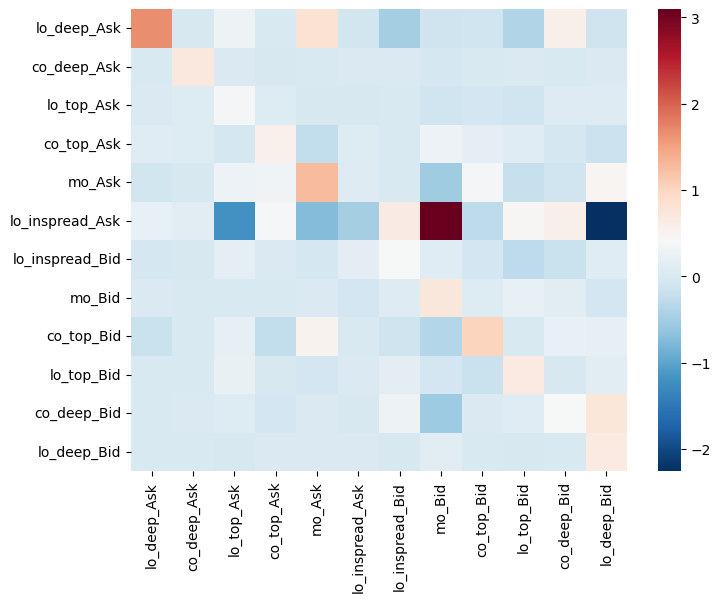

In [15]:
dimensions = cols 
sns_plot = sns.heatmap(G_pred.T,cmap="RdBu_r",xticklabels=dimensions,yticklabels=dimensions)

In [16]:
boundsDict = {}
for i in range(n_cols):
    for j in range(n_cols):
        boundsDict[cols[i]+"->"+cols[j]] = np.sign(G_pred[i][j])

with open(os.path.join(outputs_path, model_name, "fake_2019-01-02_2019-03-31_graphDict"), "wb") as f:
    pickle.dump(boundsDict, f)

## 12D Hawkes Non-Parametric Fit:

In [17]:
ric = "fake"
dictIp = {}
d = 0
l = dataLoader(ric, d, d, dataPath = os.path.join(outputs_path, model_name))
for d in range(n_sims):
    dictIp[d] = []

path_dictTOD = os.path.join(inputs_path, model_name, "fakeData_Params_sod_eod_dictTOD_constt")
cls = ConditionalLeastSquaresLogLin(dictIp, loader = l, solver="osqp", path_dictTOD = path_dictTOD)
thetas = cls.fitConditionalInSpread(spreadBeta = 1., avgSpread = 1.)
with open(os.path.join(l.dataPath, f"{ric}_Params_2019-01-02_2019-03-31_CLSLogLin_19"), "wb") as f:
    pickle.dump(thetas, f)

lo_deep_Ask
(14,)
(14,)
      bin  lo_deep_Ask  spread
0       1            1    0.01
1   30127            1    0.01
2   44080            1    0.02
3  349619            1    0.01
4  397506            1    0.01
co_deep_Ask
(41,)
(41,)
   bin  co_deep_Ask  spread
0    1            2    0.01
1    2            2    0.01
2    3            2    0.01
3    7            1    0.01
4  294            1    0.01
lo_top_Ask
(16,)
(16,)
      bin  lo_top_Ask  spread
0       1           2    0.01
1       4           1    0.01
2  275540           1    0.01
3  406920           1    0.01
4  458549           1    0.01
co_top_Ask
(13,)
(13,)
     bin  co_top_Ask  spread
0      1           1   0.010
1      6           1   0.010
2    180           2   0.015
3    191           1   0.010
4  42215           1   0.020
mo_Ask
(16,)
(16,)
      bin  mo_Ask  spread
0       1       1    0.01
1   19139       1    0.01
2   36932       1    0.02
3  117746       1    0.01
4  117754       1    0.01
lo_inspread_Ask
(5,)
(5

## Infer power law params:

In [22]:
# inference = ParametricFit(dataPath=os.path.join(outputs_path, model_name))
# a, b = inference.run(dt.date(2019,1,2), dt.date(2019,3,31), ric = "fake" , avgSpread = 0.01, spreadBeta=1. , suffix = "_CLSLogLin_19")

# Simulate LOB from Fitted Fake Params

In [21]:
# #### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
# for i in range(10):
#     T, lob, lobL3=simulate.simulate(6.5*3600, "fake_ParamsInferredWCutoff_2019-01-02_2019-01-31_CLSLogLin_19", "fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = 0.01, spread0 = 5, price0 = 45)
#     with open("./simulated_data/fake_simulated_CLSLogLinFit_sod_eod_"+ str(i) , "wb") as f:
#         pickle.dump((T, lob, lobL3), f)